# Vowpal Wabbit Tutorial

[Vowpal Wabbit (VW)](https://vowpalwabbit.org/) is a fast online machine learning (ML) library.

VW is extremely useful as a baseline for us at Sisu because it is one of the few open source approaches to fitting linear (and polynomial) models which supports the scale and parallelism for our data sets.

There are already lots of grea resources for learning about VW. The focus of this presentation will be purely on the high-level basics of working with VW in a supervised ML setting and mostly about parallelizing its training procedure.

Lots of great resources on VW already exist to cover scope outside of this:

 - A [python interface tutorial](https://vowpalwabbit.org/) 
 - The full [Github wiki](https://github.com/VowpalWabbit/vowpal_wabbit/wiki)
 - Amazing NLP [examples](https://github.com/hal3/vwnlp)
 - A [functionality overview](https://www.zinkov.com/posts/2013-08-13-vowpal-tutorial/)
 - Feature [hashing](https://arxiv.org/abs/0902.2206)
 - Installation
 
VW is a very generic and flexible system for reinforcement learning, recommendations, learning-to-search-based structured output prediction, active learning, and topic modelling.

## Basics

We'll use the [RCV1](https://www.jmlr.org/papers/v5/lewis04a.html) dataset, which contains

 - normalized [TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) features for news articles
 - a manual classification of the topic of each article
 
For simplicity we use the libsvm preprocessed datasets, with positive labels corresponding to CCAT (Corporate category) or ECAT (Economic category) and negative to GCAT (Goverment category) or MCAT (Markets category). In principle we'd want to model the full multiclass problem here (and VW is capable of doing so) but since the focus of this tutorial is on performance and parallel processing rather than preprocessing, we will be using the binary problem. That said---hopefully the utility of a classifier like this is clear. If you've ever filed a JIRA or Asana ticket, you probably had an easy time filling in the natural language description but found the tagging and prioritization field entry a chore.

Note further, that for the same reason, I'll use a different train/test split than usually applied to RCV1 to make training harder (i.e., larger train set). This is not standard for RCV1.

In [1]:
%%bash

mkdir -p vw-tutorial
cd vw-tutorial

train=https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/rcv1_train.binary.bz2
test=https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/rcv1_test.binary.bz2
test -f rcv1_train.binary.bz2 || test -f rcv1_train.binary || curl  -s $train -o rcv1_train.binary.bz2 &
test -f rcv1_test.binary.bz2 || test -f rcv1_test.binary || curl -s $test -o rcv1_test.binary.bz2 &
wait

test -f rcv1_train.binary || bunzip2 rcv1_train.binary.bz2 &
test -f rcv1_test.binary || bunzip2 rcv1_test.binary.bz2 &
wait

wc -l rcv1*

    677399 rcv1_test.binary
     20242 rcv1_train.binary
    697641 total


At this point, we've downloaded our datasets and are ready to chop them up so that we have a larger train set (to evaluate how performance improves). While we're at it, let's format these text files into something VW expects.

Right now, they're in libsvm format, which is

```
target feature1:value feature2:value ...
```

Where features are integers and for binary problems the target is `-1` or `+1`. Vowpal wabbit has a far more flexible format, which allows weighing examples, tagging examples, namespacing features, and having non-integer feature keys. Feature hashing has very interesting implications for ML, but at this level we can view it as a convenience for not needing to specify which feature maps to which index up-front.

VW supports binary classification through logistic regression. The most basic VW input format (with no feature namespaces, tags, default-valued features, or weights) looks like

```
target | feature1:value feature2:value...
```

and in our problem needs a binary target (also positive/negative 1).

In [2]:
%%bash
cd vw-tutorial

echo "libsvm format"
head -3 rcv1_train.binary | cut -c-80 | sed 's/$/.../'

cat rcv1_train.binary rcv1_test.binary \
  | sed 's/^-1/-1 |/' \
  | sed 's/^0/-1 |/' \
  | sed 's/^+1/+1 |/' \
  | sed 's/^1/+1 |/' \
  | head -n 500000 > train.vw
  

cat rcv1_train.binary rcv1_test.binary \
  | sed 's/^-1/-1 |/' \
  | sed 's/^0/-1 |/' \
  | sed 's/^+1/+1 |/' \
  | sed 's/^1/+1 |/' \
  | tail -n +500001 > test.vw
  
echo "vw format"
head -3 train.vw | cut -c-80 | sed 's/$/.../'
  
wc -l *.vw

libsvm format
1 440:0.033906222568727 730:0.0424739279722748 1523:0.0773048148348295 1893:0.04...
1 271:0.0646290650479301 405:0.0653366028581683 584:0.0744087075001463 770:0.071...
1 577:0.0679078686536282 761:0.0506946081073312 1523:0.0487487662585784 1897:0.0...
vw format
+1 | 440:0.033906222568727 730:0.0424739279722748 1523:0.0773048148348295 1893:0...
+1 | 271:0.0646290650479301 405:0.0653366028581683 584:0.0744087075001463 770:0....
+1 | 577:0.0679078686536282 761:0.0506946081073312 1523:0.0487487662585784 1897:...
    500000 shuf.vw
    197641 test.vw
    500000 train.vw
   1197641 total


Before we jump into VW usage, we can get a sense of our dataset beyond the train/test size by asking

 - what's the number of features
 - what's the average number of nonzeros per row
 - what's the pos/neg breakdown

In [3]:
%%bash
cd vw-tutorial

words=$(parallel --pipepart 'cut -f3- -d" " | wc -w' :::: train.vw | datamash sum 1)
lines=$(parallel --pipepart 'cut -f3- -d" " | wc -l' :::: train.vw | datamash sum 1)

echo "words $words"
echo "lines $lines"
echo "avg nnz $(( $words / $lines ))"

words 36655000
lines 500000
avg nnz 73


In [4]:
%%bash
cd vw-tutorial

parallel --pipepart '
cut -f3- -d" " \
| sed -E '"'"'s/([0-9]+):\S+/\1/g'"'"' \
| tr " " "\n" \
| datamash max 1' :::: train.vw | datamash max 1

47236


In [5]:
%%bash
cd vw-tutorial

negs=$(parallel --pipepart grep -c "^-1" :::: train.vw | datamash sum 1)
poss=$(parallel --pipepart grep -c "^+1" :::: train.vw | datamash sum 1)
lines=$(parallel --pipepart 'cut -f3- -d" " | wc -l' :::: train.vw | datamash sum 1)

echo "neg $negs ($(($negs * 100 / $lines))%)"
echo "pos $poss ($(($poss * 100 / $lines))%)"
echo "lines $lines"

neg 234187 (46%)
pos 265813 (53%)
lines 500000


Time to train!!

In [6]:
%%bash

# RECOMMENDED -- run in command line to see output
exit 0

cd vw-tutorial

# --bit_precision / -b defaults to 18, or 2^18. Default ints are unhashed so this is plenty
# for our tiny little 47K dimensional problem, in fact we can downgrade to 16 bits

# --loss_function defaults to square loss, but in our case we want logistic. We could do hinge.

# --final_regressor / -f writes the output model after training to a file

vw --bit_precision 16 --loss_function logistic --final_regressor b16o1.model train.vw

Interpreting VW output: running under default as above does _no_ shuffling of the data and runs a single online pass through the dataset. In typical online convex optimization fashion, this relies on a standard square-root decay in learning rate, but this is controllable through various parameters.

By default, VW's online update has lots of extra bells and whistles (adaptivity based on AdaGrad, normalization based on [normalized online gradient](http://www.cs.cmu.edu/~sross1/publications/uai13_normalized.pdf), weighted steps based on an invariant [continuous differential equation](https://arxiv.org/abs/1011.1576) solve), which we won't touch on here. The code is freely [available](https://github.com/VowpalWabbit/vowpal_wabbit/blob/master/vowpalwabbit/gd.cc).

```
final_regressor = b16o1.model
Num weight bits = 16
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = train.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
0.693147 0.693147            1            1.0   1.0000   0.0000      182
0.579074 0.465001            2            2.0   1.0000   0.5242      142
0.722714 0.866353            4            4.0  -1.0000   0.8827      145
0.640078 0.557442            8            8.0  -1.0000  -0.9066      198
0.640367 0.640657           16           16.0  -1.0000  -1.7261      190
0.554364 0.468360           32           32.0   1.0000   0.2800       32
0.485971 0.417578           64           64.0  -1.0000  -0.1567       66
0.461202 0.436432          128          128.0   1.0000   1.6216      150
0.421228 0.381255          256          256.0  -1.0000  -0.3880      126
0.355553 0.289877          512          512.0   1.0000   1.4453       30
0.336748 0.317943         1024         1024.0  -1.0000  -0.2843      101
0.291487 0.246226         2048         2048.0   1.0000   0.5170       70
0.248249 0.205011         4096         4096.0   1.0000   4.6111       67
0.202177 0.156104         8192         8192.0   1.0000   3.3094       38
0.169778 0.137379        16384        16384.0  -1.0000  -2.1202      116
0.142966 0.116154        32768        32768.0   1.0000   5.1527       37
0.123728 0.104490        65536        65536.0  -1.0000  -7.0800      108
0.104505 0.085282       131072       131072.0   1.0000   8.0332       64
0.093636 0.082766       262144       262144.0  -1.0000  -5.0297      109

finished run
number of examples per pass = 500000
passes used = 1
weighted example sum = 500000.000000
weighted label sum = 31626.000000
average loss = 0.084595
best constant = 0.126673
best constant's loss = 0.691145
total feature number = 37155000
```
To discuss: all columns / values above. Note loss here is based on [progressive validation](https://www.cs.cmu.edu/~jcl/papers/progressive_validation/coltfinal.pdf) while in this online mode.

This online mode showcase the speed of VW: 0.5M examples in a few seconds!

## Evaluation

Running VW in `--testonly` mode lets us evaluate our existing model.

In [7]:
%%bash

cat vw-eval.sh

#!/bin/bash
# Usage: bash vw-eval.sh cwd model testfile cache

cd "$1"

model="$2"
testfile="$3"
cache="$4"

acc=$(vw --binary --testonly --cache_file "${testfile}.${cache}" -i "$model" "$testfile" 2>&1 | grep "average loss" | cut -d"=" -f2)
acc=$(echo "$acc" | awk '{printf "%.6f\n", 1-$1}')
echo "acc     $acc"

logloss=$(vw --loss_function logistic --testonly --cache_file "${testfile}.${cache}" -i "$model" "$testfile" 2>&1 \
    | grep "average loss" | cut -d"=" -f2 )
logloss=$(echo "$logloss" | awk '{printf "%.6f\n", $0}')
echo "logloss $logloss"


In [8]:
%%bash

echo "train"
bash vw-eval.sh vw-tutorial b16o1.model train.vw b16.cache
echo "test"
bash vw-eval.sh vw-tutorial b16o1.model test.vw b16.cache

# RECOMMENDED -- run below in command line to see output
exit 0

cd vw-tutorial

# --initial_regressor / -i sets the initial model, both for warm starts and testing
# --testonly indicates that we shouldn't be doing any training
# --binary gives classification accuracy vs. logistic loss
vw --loss_function logistic --testonly -i b16o1.model test.vw
vw --binary --testonly -i b16o1.model test.vw

train
acc     0.979274
logloss 0.065122
test
acc     0.975162
logloss 0.076964


## Multiple Passes and Caching

We can see above that single-pass VW does a pretty good job at not overfitting. Since the learning rate tunes down, we could still reasonable still get some perf improvements with more passes.

Since we're passing over the dataset multiple times, it's worthwhile to cache the parsed dataset.

VW typically has a parser thread and core update thread. The parser thread can easily end up dominating runtime! It's responsible for taking an example line in the above format and parse it into a sparse vector corresponding to the active features in each line.

We tell VW to create (and re-use) a cache file with pre-parsed lines in an internal binary format. `-c / --cache` specifies to use a cache file at train + `.cache` (as opposed to a directed location `--cache_file`) and `-k / --kill_cache` clears it on re-runs.

In [9]:
%%bash

cd vw-tutorial

echo "no cache"
/usr/bin/time -f "%e sec" bash -c 'vw -b 16 --loss_function logistic train.vw 2>/dev/null' 2>&1
echo "create cache"
/usr/bin/time -f "%e sec" bash -c 'vw -c -k -b 16 --loss_function logistic train.vw 2>/dev/null' 2>&1
echo "reuse cache"
/usr/bin/time -f "%e sec" bash -c 'vw -c -b 16 --loss_function logistic train.vw 2>/dev/null' 2>&1

# RECOMMENDED - run in command line
exit 0

/usr/bin/time -f "%e sec" vw --cache --passes 100 --bit_precision 16 \
  --loss_function logistic --final_regressor b16o1p10.model train.vw

no cache
5.10 sec
create cache
5.63 sec
reuse cache
0.84 sec


In multi-pass mode, VW will use a holdout by using every 10th example as a validation example. This is used by default for early stopping (in the sample output, notice the `h` indicating as much). All of these options are configurable.

Notice that when we consider just a regular order-1 model, extra training doesn't buy us much. Note that if we wanted to train a linear regression to convergence on a full dataset without validation, we'd need to loop over a single pass invocation, using `-i` to specify the previous warm start, `--holdout_off` to use the full set, and check for progressive validation loss convergence (which in this case would be equal to a lagged train loss).

In [10]:
%%bash

echo "train"
bash vw-eval.sh vw-tutorial b16o1p100.model train.vw b16.cache
echo "test"
bash vw-eval.sh vw-tutorial b16o1p100.model test.vw b16.cache

train
acc     0.985144
logloss 0.046969
test
acc     0.975703
logloss 0.074126


## Higher Degrees and Regularization

To push to a more sophisticated model, we can consider `-q / --quadratic` features between every pair `::` (can be used to restrict to cross terms between certain namespaces.

At this point we need to start considering some regularization, `--l1` or `--l2`.

Further, we'll introduce `--hash all` (instead of default `strings`) which hashes the order-1 features as well as higher-order features into a larger bit vector. I like to turn this on for higher-degree polynomials since the default mapping of order-1 features ensures no collisions on the order-1s, which may not actually be what we want to optimize for if a lot of the order-1 features are null.

In [11]:
%%bash

# typically requires a minute or so
pushd vw-tutorial >/dev/null
time vw --hash all -q :: -b 20 --loss_function logistic -f b20o2.model \
  --l1 1e-6 --l2 1e-6 \
  --cache_file train.vw.b20.cache train.vw 2>/dev/null
popd >/dev/null
bash vw-eval.sh vw-tutorial b20o2.model test.vw b20.cache

acc     0.980394
logloss 0.071671



real	1m35.755s
user	1m49.573s
sys	0m2.862s


A couple things to note here: the regularization constant is *per datapoint*, so we need to divide our typical setting by the dataset size. Also, it takes a *long while* to train, even with one pass, because of the quadratic feature expansion, but we are paid off with a bit of accuracy improvement.

You can see the parser + runner threads at work in htop!

Even more interesting option (not sure how sensible it is to parallelize though, that might break guarantees) is `--stage_poly`, but that's a bit advanced. See the relatively unknown [apple](https://arxiv.org/abs/1410.0440) paper.

## VW Parallelization

OK, but say we want to have it all: higher-order polynomials and fast (since higher order kernel evaluation is expensive). VW comes with a super cool shared-nothing process-based paralellism system, which you can run on shards of your dataset.

Every so often, e.g., between epochs, an all-reduce operation is run, averaging the weights (it's a little more clever than that, in that you have adaptive learning rates, but essentially it's averaging). The critical operation here is summing up the coefficient vectors across all active nodes.

![all reduce semantics](https://tech.preferred.jp/wp-content/uploads/2018/07/fig_1.png)

There are lots of way of implementing all-reduce (in multi-GPU neural network training, such as in Horovod, the minimal-communication "ring" pattern is used, which passes an accumulator in a ring across all GPUs, albeit requiring a linear latency). For linear coefficient vectors there's less of a throughput bottleneck due to weight transfer being smaller, so the higher-communication but lower-latency tree reduce is used.


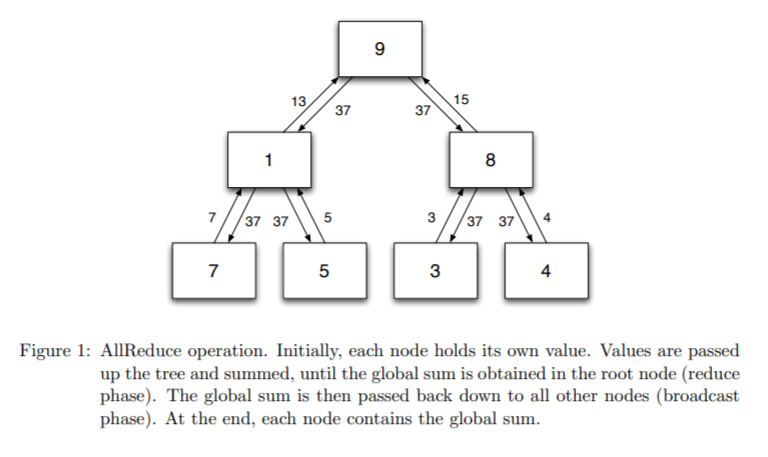

[Paper link](https://jmlr.org/papers/volume15/agarwal14a/agarwal14a.pdf).

In order to set up the tree hierarchy and manage synchronization, individual VW nodes need to be set up against a span server.

Moreover, we need to preprocess the dataset a bit to split it up into chunks. But after that, we're home free! Notice that in typicall allreduce fashion, all nodes emit their own copies of the final model, so we need to make sure they won't all write over each other.

In [12]:
%%bash
cd vw-tutorial

mkdir -p sharded-files
cd sharded-files
rm *

njobs=$(nproc)
echo "njobs $njobs"
shuf ../train.vw > shuf.vw

split -n l/$njobs -a 2 -d shuf.vw train.vw.
ls

njobs 32
shuf.vw
train.vw.00
train.vw.01
train.vw.02
train.vw.03
train.vw.04
train.vw.05
train.vw.06
train.vw.07
train.vw.08
train.vw.09
train.vw.10
train.vw.11
train.vw.12
train.vw.13
train.vw.14
train.vw.15
train.vw.16
train.vw.17
train.vw.18
train.vw.19
train.vw.20
train.vw.21
train.vw.22
train.vw.23
train.vw.24
train.vw.25
train.vw.26
train.vw.27
train.vw.28
train.vw.29
train.vw.30
train.vw.31


In [13]:
%%bash

# sets up spanning tree server on some default port

nohup spanning_tree >/tmp/span.out 2>/tmp/span.err &

# then tail -f /tmp/span.err

In [14]:
! cat vw-train.sh

# unique identifier for the job (the span server supports multiple jobs at once)
jobid="$RANDOM"

cd vw-tutorial
cd sharded-files

njobs=$(nproc)

# use gnu parallel to generate commands

cmd="vw --bit_precision 24 --loss_function logistic"
# cmd="$cmd --kill_cache --cache --passes 10"
cmd="$cmd -q :: --l2 1e-6 --l1 1e-6 --hash all --holdout_off"
cmd="$cmd --node {} --unique_id ${jobid} "
cmd="$cmd --span_server localhost --total ${njobs}"

start=$(date +%s.%N)
# only ask the head node to persist the model
seq -f "%02g" 0 $(($njobs - 1)) | parallel --lb '
  if [ {} -eq 0 ] ; then
      extra_args="--final_regressor parallel.model"
  fi
  echo "node {} reporting for duty"
  '"$cmd"' train.vw.{} ${extra_args} 2>/dev/null'
end=$(date +%s.%N)

dt=$(echo "$end - $start" | bc)
echo "train_sec $dt"


As an exercise: do parallel prediction too (requires some new flags we haven't seen, `parallel`, and other tools)!

In [15]:
%%bash
bash vw-train.sh

node 18 reporting for duty
node 02 reporting for duty
node 30 reporting for duty
node 27 reporting for duty
node 23 reporting for duty
node 28 reporting for duty
node 04 reporting for duty
node 17 reporting for duty
node 06 reporting for duty
node 01 reporting for duty
node 22 reporting for duty
node 24 reporting for duty
node 19 reporting for duty
node 00 reporting for duty
node 03 reporting for duty
node 10 reporting for duty
node 05 reporting for duty
node 12 reporting for duty
node 16 reporting for duty
node 29 reporting for duty
node 11 reporting for duty
node 13 reporting for duty
node 21 reporting for duty
node 25 reporting for duty
node 08 reporting for duty
node 15 reporting for duty
node 07 reporting for duty
node 14 reporting for duty
node 20 reporting for duty
node 09 reporting for duty
node 26 reporting for duty
node 31 reporting for duty
train_sec 34.944436968


In [16]:
%%bash

bash vw-eval.sh vw-tutorial sharded-files/parallel.model test.vw b24.cache

acc     0.963424
logloss 0.288551


Because parallel evaluation performs averaging, it won't do as well as single-threaded evaluation. However, for `--cubic`, we often have no choice but to leverage parallelism because of how long each example takes to evaluate.

Notice how we're able to train faster than the original quadratic but get worse accuracy.